# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=8e0c9385e40c9dad44e2a87fc3a14f91f3172931aec65364e405323237ac0297
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import os
import sys
import shutil
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import face_recognition

# Inputs

In [ ]:
# Inputs
frames_req = 20
selected_frame = 11
video_filepath = '/content/drive/MyDrive/ml-project/goodbye toby.mp4'

# Video File

In [ ]:
labels_to_emotion = {0: 'anger',
                    1: 'disgust',
                    2: 'fear',
                    3: 'happy',
                    4: 'neutral',
                    5: 'sadness',
                    6: 'surprise'}

# Extracting Frame from video

### Getting the frame

In [ ]:
#@title
print("Getting frame for video: {}".format(video_filepath))

def get_faces(path):
    image = face_recognition.load_image_file(path)
    face_locations = face_recognition.face_locations(image)
    faces = []
    for i, face in enumerate(face_locations):
        top, right, bottom, left = face
        faces.append(image[top:bottom, left:right])
    return faces

def get_frame(sec, vid_cap, count, filename):
    # since we are only selecting the middle frame now
    if count != selected_frame:
      return None

    vid_cap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    has_frames, image = vid_cap.read()
    if has_frames:
        return image

    return None

video_file = video_filepath

filename, ext = os.path.splitext(video_file)
vid_cap = cv2.VideoCapture(video_file)

frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = vid_cap.get(cv2.CAP_PROP_FPS) 
filename = filename.split('/')[-1]

sec = 0
frame_rate = frame_count / (frames_req * fps)
count = 1

while count != selected_frame:
    count = count + 1
    sec = sec + frame_rate
    sec = round(sec, 2)

img = get_frame(sec, vid_cap, count, filename)
final_img = img

Getting frame for video: /content/drive/MyDrive/ml-project/goodbye toby.mp4


### Getting the Faces from frame

In [ ]:
#@title
all_video_faces = []

from dlib import get_frontal_face_detector
import time

hog_face_detector = get_frontal_face_detector()

def hog_detect_face(image, hog_face_detector, display = True):
    '''
    This function performs face(s) detection on an image using dlib hog face detector.
    Args:
        image:             The input image of the person(s) whose face needs to be detected.
        hog_face_detector: The hog face detection model required to perform the detection on the input image.
        display:           A boolean value that is if set to true the function displays the original input image, 
                           and the output image with the bounding boxes drawn and time taken written and returns nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    # Get the height and width of the input image.
    height, width, _ = image.shape
    # Create a copy of the input image to draw bounding boxes on.
    output_image = image.copy()
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    # Perform the face detection on the image.
    results = hog_face_detector(imgRGB, 0)

    faces = []

    # Loop through the bounding boxes of each face detected in the image.
    for bbox in results:    
        # Retrieve the left most x-coordinate of the bounding box.
        x1 = bbox.left()
        # Retrieve the top most y-coordinate of the bounding box.
        y1 = bbox.top()
        # Retrieve the right most x-coordinate of the bounding box.
        x2 = bbox.right()
        # Retrieve the bottom most y-coordinate of the bounding box.       
        y2 = bbox.bottom()

        cimg = imgRGB[y1:y2, x1:x2]
        try:
            cimg_resized = cv2.resize(cimg, (48, 48))
            cimg = cimg_resized
            faces.append(cimg)
            # Draw a rectangle around a face on the copy of the image using the retrieved coordinates.
            cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=width//200)
        except:
            print("could not resize image!")
    
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        # Return the output image and results of face detection.
        return faces

def get_frame(sec, vid_cap, count, output_directory, filename, output_ext):
    # since we are only selecting the middle frame now
    if count != selected_frame:
      return True
    vid_cap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    has_frames, image = vid_cap.read()

    if has_frames:
        # TODO - we need to get all faces from the frame and write that
        faces = hog_detect_face(image, hog_face_detector, display=False)
        if faces is not None and len(faces) != 0:
            num_faces = len(faces)
            face_count = 1
            for face in faces:
                all_video_faces.append(face)
    return has_frames

def convert_video_to_frames(video_file, output_directory, output_ext="jpg"):
    all_video_faces = []

    """Converts video to multiple frames using OpenCV library"""
    filename, ext = os.path.splitext(video_file)
    vid_cap = cv2.VideoCapture(video_file)
    
    frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid_cap.get(cv2.CAP_PROP_FPS) 
    filename = filename.split('/')[-1]
    
    if fps == 0 or frame_count == 0:
        print("No frames in {}. Skipping!".format(filename))
        return
    
    sec = 0
    frame_rate = frame_count / (frames_req * fps)
    count = 1
    
    # print("Getting frames for {}".format(filename))
    success = get_frame(sec, vid_cap, count, output_directory, filename, output_ext)
    
    while success:
        count = count + 1
        sec = sec + frame_rate
        sec = round(sec, 2)
        
        if count > frames_req:
            break
        
        success = get_frame(sec, vid_cap, count, output_directory, filename, output_ext)

convert_video_to_frames(video_filepath, '')
print("Number of faces: ", len(all_video_faces))

Number of faces:  1


### Importing the model to predict

In [ ]:
from tensorflow import keras
import numpy as np
BASE_PATH = '/content/drive/MyDrive/ml-project/FaceDataset'
MODEL_DIR = BASE_PATH + '/model'
# '/content/drive/MyDrive/ml-project/MELD.Raw/face_detection_model/model_e_06.h5'
# MODEL_DIR + "/model.h5"
model = keras.models.load_model(MODEL_DIR + "/model.h5")
keras.models

<module 'keras.api._v2.keras.models' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/models/__init__.py'>

In [ ]:
# Extract features out of image
if (all_video_faces is None or len(all_video_faces) == 0):
    print('No face found!')
else:
    test_img_array = [np.array(face).reshape(48, 48, 1) for face in all_video_faces] 
    test_img_array = [cv2.merge((img, img, img)) for img in test_img_array]
    test_img_array = np.stack(test_img_array, axis=0)
    test_img_array.shape # (21264, 48, 48, 1)

    test_img_array = test_img_array / 255.

    test_hyp = model.predict(test_img_array)

# Final Output

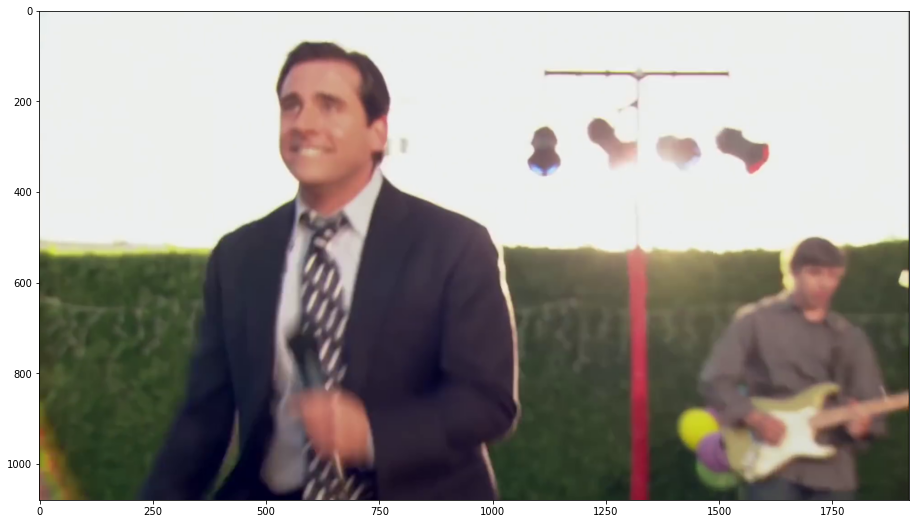

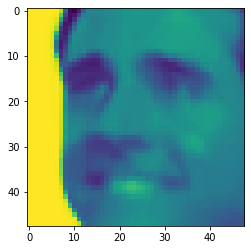

The image is describing: happy
probabilities: 
[[0.02123761 0.0008646  0.05162981 0.81005657 0.09794114 0.00311229
  0.01515801]]
Label Encoding: 
{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [ ]:
#@title
img = final_img
fig = plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

for face in all_video_faces:
    plt.imshow(face)

plt.show()

print("The image is describing: {}".format(labels_to_emotion[np.argmax(test_hyp)]))
print('probabilities: \n{}'.format(test_hyp))
print('Label Encoding: \n{}'.format(labels_to_emotion))